# Import Modules

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
from tqdm.auto import tqdm
import time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

# Import Dataset

In [94]:
df = pd.read_csv("movies_new.csv")
df = df.sort_values(by="startYear")
df.drop(columns=["originalTitle"], inplace=True)
df_recent = df[df["startYear"] >= 2015] 
print(f"Features: {df_recent.columns}")
print(f"Shape: {df_recent.shape}")

Features: Index(['tconst', 'titleType', 'primaryTitle', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'HitScore'],
      dtype='object')
Shape: (113868, 10)


In [95]:
df["genres"].value_counts()

genres
Documentary                 35908
Drama                       30969
Comedy                      14468
Comedy,Drama                 6299
Horror                       6177
                            ...  
Adult,Comedy,Crime              1
Documentary,Horror,Music        1
Drama,Horror,Sport              1
Adult,Fantasy,Romance           1
Comedy,Crime,War                1
Name: count, Length: 1124, dtype: int64

In [96]:
genre = "Comedy"
# df = df[df['genres'].str.contains("Comedy", case=True)]
df = df[df["genres"] == "Comedy"]
print(f"{df.shape}")

(14468, 10)


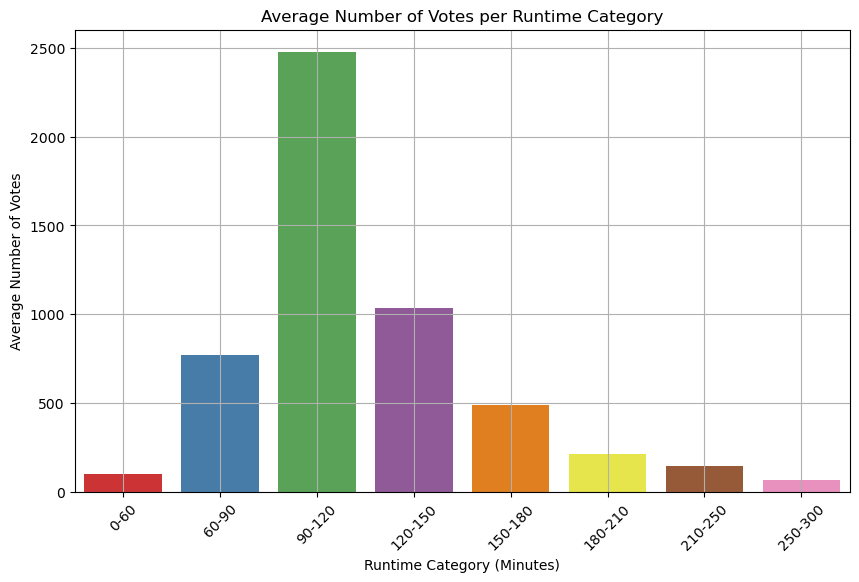

In [97]:

df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')


# Define bins for runtimes
bins = [0, 60, 90, 120, 150, 180, 210, 250, 300]
bin_labels = ['0-60', '60-90', '90-120', '120-150', '150-180', '180-210', '210-250', '250-300']

# Add a column for runtime categories
df['runtime_category'] = pd.cut(df['runtimeMinutes'], bins=bins, labels=bin_labels)

# Group by runtime categories and calculate the mean number of votes in each category
runtime_vote_group = df.groupby('runtime_category', observed=False)['numVotes'].mean().reset_index()

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(data=runtime_vote_group, x='runtime_category', y='numVotes', palette='Set1', hue=bin_labels)  # Set hue=None to silence warning
plt.title('Average Number of Votes per Runtime Category')
plt.xlabel('Runtime Category (Minutes)')
plt.ylabel('Average Number of Votes')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


## Data Preprocessing 

#### Feature Engineering

In [98]:
# Convert to list
df['genres'] = df['genres'].replace('\\N', 'Unknown')
df['genres_list'] = df['genres'].apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres_list'])  # Fit & transform genres

genre_columns = mlb.classes_  # Get genre names as column names
df[genre_columns] = genre_encoded  # Add encoded genres to DataFrame

##select runTime
df = df[(df['runtimeMinutes'] >= 60) & (df['runtimeMinutes'] <= 250)]

##check for missing values
print(f"{df['averageRating'].isna().sum()}")
print(f"{df['numVotes'].isna().sum() }")

0
0


### Relationship of averageRating, HitScore and total votes

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/csrc-student/miniconda3/envs/aries/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/home/csrc-student/miniconda3/envs/aries/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/home/csrc-student/miniconda3/envs/aries/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/csrc-student/miniconda3/envs/aries/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/csrc-student/miniconda3/envs/aries/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/csrc-student/miniconda3/envs/aries/lib/python3.12/threading.py", line 1012, in r

KeyError: 'numVotes_log'

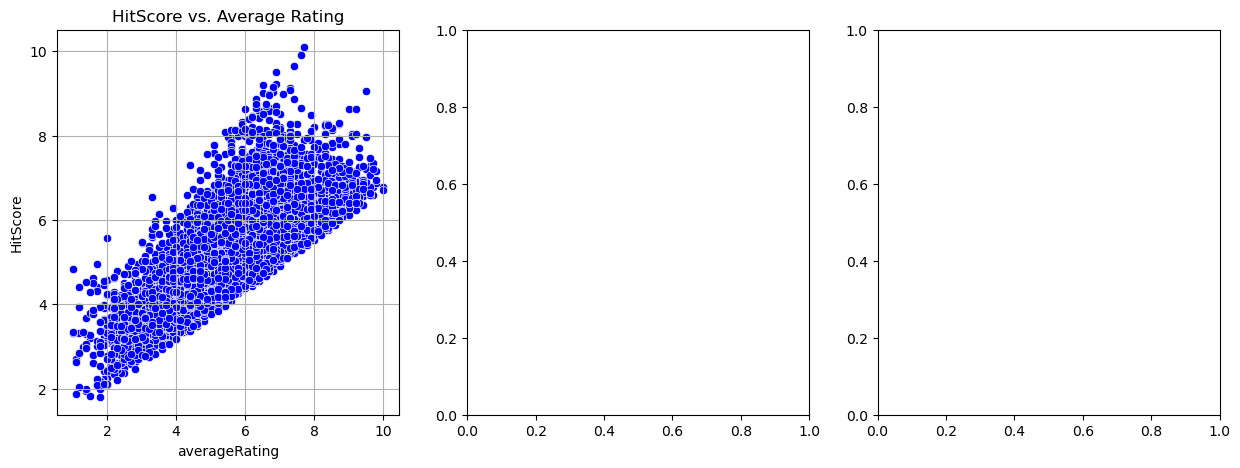

In [99]:
# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot: HitScore vs averageRating
sns.scatterplot(x=df['averageRating'], y=df['HitScore'], ax=axes[0], color='b')
axes[0].set_title('HitScore vs. Average Rating')
axes[0].grid(True)

# Scatter plot: HitScore vs numVotes_log
sns.scatterplot(x=df['numVotes_log'], y=df['HitScore'], ax=axes[1], color='r')
axes[1].set_title('HitScore vs. NumVotes (log)')
axes[1].grid(True)  

# Scatter plot: averageRating vs numVotes_log
sns.scatterplot(x=df['averageRating'], y=df['numVotes_log'], ax=axes[2], color='g')
axes[2].set_title('Average Rating vs. NumVotes (log)')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df[['averageRating', 'numVotes_log', 'HitScore']].corr()
corr_matrix


### Unique Genres

In [100]:
unique_genres = df['genres'].str.split(',').explode().str.strip().unique()
print(unique_genres)

['Comedy']


## Format For Vanilla MLP

### Features and Target

In [101]:
df['isAdult'] = df['isAdult'].astype(int)  
df['numVotes_log'] = np.log1p(df['numVotes'])


# **Define numerical & categorical features**
num_features = ['averageRating', 'numVotes_log']
cat_features = list(genre_columns)  # One-hot encoded genres

# Define features and target
# X = df[num_features].to_numpy()
X = df[num_features + cat_features].to_numpy()
y = df['HitScore'].to_numpy().reshape(-1,1)

# ## Get a subset of the dataset for faster training
# X = X[:1000,:]
# y = y[:1000,:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"{X_train.shape[0] + X_test.shape[0] == df.shape[0]}")
# print(f"{X_train.shape[0] + X_test.shape[0] == df.iloc[:1000,:].shape[0]}")

True


In [80]:
X.shape

(10976, 3)

### Normalize the dataset

In [13]:
# scalerX = StandardScaler()
# X_train_scaled = scalerX.fit_transform(X_train)  # Fit on training set
# X_test_scaled = scalerX.transform(X_test)

# **Apply StandardScaler ONLY on training set**
scalerX = StandardScaler()
X_train[:, :len(num_features)] = scalerX.fit_transform(X_train[:, :len(num_features)])  
X_test[:, :len(num_features)] = scalerX.transform(X_test[:, :len(num_features)])


scalerY = StandardScaler()
y_train_scaled = scalerY.fit_transform(y_train)  
y_test_scaled = scalerY.transform(y_test) 

### Convert to Tensors

In [14]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


# Check shapes
print(X_train.shape, y_train_scaled.shape)
print(X_test.shape, y_test_scaled.shape)

(800, 29) (800, 1)
(200, 29) (200, 1)


### Dataloaders

In [16]:
import os
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16  

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train_dataloader}\nTest dataloader: {test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")
print(f"=============================================================================="*100)

Dataloaders:
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x72acc2fac5f0>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x72acc2faedb0>
Length of train dataloader: 50 batches of 16
Length of test dataloader: 13 batches of 16


## Format for Sequential/Time Series

### Features and Target

In [103]:
df['isAdult'] = df['isAdult'].astype(int)  
df['numVotes_log'] = np.log1p(df['numVotes'])


# **Define numerical & categorical features**
num_features = ['averageRating', 'numVotes_log']
cat_features = list(genre_columns)  # One-hot encoded genres

# Define features and target
# X= df[['averageRating', 'numVotes_log']].to_numpy()
X1 = df[num_features].to_numpy()
y1 = df['HitScore'].to_numpy().reshape(-1,1)

# X1 = X1[:10000,:]
# y1 = y1[:10000,:]

# Split data into training (80%) and temp (20%)
X1_train, X_temp, y1_train, y_temp = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Further split temp (20%) into validation (10%) and test (10%)
X_val, X1_test, y_val, y1_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"{X1_train.shape[0] + X_val.shape[0] + X1_test.shape[0] == df.shape[0]}")
# print(f"{X1_train.shape[0] + X1_test.shape[0] + X_val.shape[0] == df.iloc[:1000,:].shape[0]}")

True


In [104]:
scalerX = StandardScaler()
# X1_train[:,:len(num_features)] = scalerX.fit_transform(X1_train[:,:len(num_features)])
# X1_test[:,:len(num_features)] = scalerX.transform(X1_test[:,:len(num_features)])
# X_val[:,:len(num_features)] = scalerX.transform(X_val[:,:len(num_features)])
X1_train_scaled = scalerX.fit_transform(X1_train)  # Fit on training set
X1_test_scaled = scalerX.transform(X1_test)
X_val_scaled = scalerX.transform(X_val[:,:len(num_features)])  # Apply on test set


scalerY = StandardScaler()
y1_train_scaled = scalerY.fit_transform(y1_train)  # Fit on training set
y1_test_scaled = scalerY.transform(y1_test)  # Apply on test set
y_val_scaled = scalerY.transform(y_val)  # Apply on validation test set

### Convert the data into a sequential type

In [105]:
# Define time step 
def create_sequences(X, y, time_step=8):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:i+time_step]) 
        ys.append(y[i+time_step])    # Target is the next year
    return np.array(Xs), np.array(ys)

# Convert datasets into 3D shape (samples, time steps, features)
X_train_seq, y_train_seq = create_sequences(X1_train_scaled, y1_train_scaled)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled)
X_test_seq, y_test_seq = create_sequences(X1_test_scaled, y1_test_scaled)

# Check shapes
print("Train shape:", X_train_seq.shape)  # (samples, time_steps, features)
print("Val shape:", X_val_seq.shape)
print("Test shape:", X_test_seq.shape)

Train shape: (8772, 8, 2)
Val shape: (1090, 8, 2)
Test shape: (1090, 8, 2)


### Convert to Tensors

In [106]:
# Convert to PyTorch tensors
X1_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
X1_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

y1_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32)
y1_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)


# Check shapes
print(X1_train_tensor.shape, y1_train_tensor.shape)
print(X_val_tensor.shape, y_val_tensor.shape)
print(X1_test_tensor.shape, y1_test_tensor.shape)

torch.Size([8772, 8, 2]) torch.Size([8772, 1])
torch.Size([1090, 8, 2]) torch.Size([1090, 1])
torch.Size([1090, 8, 2]) torch.Size([1090, 1])


### Use Dataloaders from PyTorch

In [107]:
import os
# Create TensorDatasets
train_dataset = TensorDataset(X1_train_tensor, y1_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X1_test_tensor, y1_test_tensor)

# Create DataLoaders
batch_size = 64 

train1_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False) 
test1_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train1_dataloader}\nTest dataloader: {test1_dataloader}")
print(f"Length of train dataloader: {len(train1_dataloader)} batches of {train1_dataloader.batch_size}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {val_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test1_dataloader)} batches of {test1_dataloader.batch_size}")
print(f"=============================================================================="*100)

Dataloaders:
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fc2549d1af0>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fc253dafcb0>
Length of train dataloader: 138 batches of 64
Length of validation dataloader: 18 batches of 64
Length of test dataloader: 18 batches of 64


# Optimizer

In [108]:
#Adan: Adaptive Nesterov Momentum Algorithm

import math
from typing import List
from torch import Tensor

class MultiTensorApply(object):
    available = False
    warned = False

    def __init__(self, chunk_size):
        try:
            MultiTensorApply.available = True
            self.chunk_size = chunk_size
        except ImportError as err:
            MultiTensorApply.available = False
            MultiTensorApply.import_err = err

    def __call__(self, op, noop_flag_buffer, tensor_lists, *args):
        return op(self.chunk_size, noop_flag_buffer, tensor_lists, *args)


class Adan(torch.optim.Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for
        Faster Optimizing Deep Models[J].arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or
            dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for
            first- and second-order moments. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay
            (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay
            (default: False)
        foreach (bool): if True would use torch._foreach implementation.
            It's faster but uses slightly more memory. (default: True)
        fused (bool, optional): whether fused implementation is used.
            (default: False)
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.98, 0.92, 0.99),
                 eps=1e-8,
                 weight_decay=0.0,
                 max_grad_norm=0.0,
                 no_prox=False,
                 foreach: bool = True,
                 fused: bool = False):
        if not 0.0 <= max_grad_norm:
            raise ValueError('Invalid Max grad norm: {}'.format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= eps:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(
                betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError('Invalid beta parameter at index 2: {}'.format(
                betas[2]))
        if fused:
            _check_fused_available()

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm,
                        no_prox=no_prox,
                        foreach=foreach,
                        fused=fused)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'],
                                         device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group['eps']),
                max=1.0).item()
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_diffs = []
            neg_pre_grads = []

            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support
            # by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1**group['step']
            bias_correction2 = 1.0 - beta2**group['step']
            bias_correction3 = 1.0 - beta3**group['step']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                grads.append(p.grad)

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                if 'neg_pre_grad' not in state or group['step'] == 1:
                    state['neg_pre_grad'] = p.grad.clone().mul_(
                        -clip_global_grad_norm)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])
                exp_avg_diffs.append(state['exp_avg_diff'])
                neg_pre_grads.append(state['neg_pre_grad'])

            if not params_with_grad:
                continue

            kwargs = dict(
                params=params_with_grad,
                grads=grads,
                exp_avgs=exp_avgs,
                exp_avg_sqs=exp_avg_sqs,
                exp_avg_diffs=exp_avg_diffs,
                neg_pre_grads=neg_pre_grads,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                bias_correction3_sqrt=math.sqrt(bias_correction3),
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
                no_prox=group['no_prox'],
                clip_global_grad_norm=clip_global_grad_norm,
            )

            if group['foreach']:
                if group['fused']:
                    if torch.cuda.is_available():
                        _fused_adan_multi_tensor(**kwargs)
                    else:
                        raise ValueError('Fused Adan does not support CPU')
                else:
                    _multi_tensor_adan(**kwargs)
            elif group['fused']:
                if torch.cuda.is_available():
                    _fused_adan_single_tensor(**kwargs)
                else:
                    raise ValueError('Fused Adan does not support CPU')
            else:
                _single_tensor_adan(**kwargs)

        return loss


def _single_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad_or_diff = neg_pre_grads[i]

        grad.mul_(clip_global_grad_norm)

        # for memory saving, we use `neg_grad_or_diff`
        # to get some temp variable in a inplace way
        neg_grad_or_diff.add_(grad)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
        exp_avg_diff.mul_(beta2).add_(neg_grad_or_diff,
                                      alpha=1 - beta2)  # diff_t

        neg_grad_or_diff.mul_(beta2).add_(grad)
        exp_avg_sq.mul_(beta3).addcmul_(neg_grad_or_diff,
                                        neg_grad_or_diff,
                                        value=1 - beta3)  # n_t

        denom = ((exp_avg_sq).sqrt() / bias_correction3_sqrt).add_(eps)
        step_size_diff = lr * beta2 / bias_correction2
        step_size = lr / bias_correction1

        if no_prox:
            param.mul_(1 - lr * weight_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
        else:
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
            param.div_(1 + lr * weight_decay)

        neg_grad_or_diff.zero_().add_(grad, alpha=-1.0)


def _multi_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    if len(params) == 0:
        return

    torch._foreach_mul_(grads, clip_global_grad_norm)

    # for memory saving, we use `neg_pre_grads`
    # to get some temp variable in a inplace way
    torch._foreach_add_(neg_pre_grads, grads)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)  # m_t

    torch._foreach_mul_(exp_avg_diffs, beta2)
    torch._foreach_add_(exp_avg_diffs, neg_pre_grads,
                        alpha=1 - beta2)  # diff_t

    torch._foreach_mul_(neg_pre_grads, beta2)
    torch._foreach_add_(neg_pre_grads, grads)
    torch._foreach_mul_(exp_avg_sqs, beta3)
    torch._foreach_addcmul_(exp_avg_sqs,
                            neg_pre_grads,
                            neg_pre_grads,
                            value=1 - beta3)  # n_t

    denom = torch._foreach_sqrt(exp_avg_sqs)
    torch._foreach_div_(denom, bias_correction3_sqrt)
    torch._foreach_add_(denom, eps)

    step_size_diff = lr * beta2 / bias_correction2
    step_size = lr / bias_correction1

    if no_prox:
        torch._foreach_mul_(params, 1 - lr * weight_decay)
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
    else:
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
        torch._foreach_div_(params, 1 + lr * weight_decay)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_multi_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    import fused_adan
    multi_tensor_applier = MultiTensorApply(2048 * 32)
    _dummy_overflow_buf = torch.cuda.IntTensor([0])
    multi_tensor_applier(
        fused_adan.adan_multi_tensor, _dummy_overflow_buf,
        [params, grads, exp_avgs, exp_avg_sqs, exp_avg_diffs, neg_pre_grads],
        beta1, beta2, beta3, bias_correction1, bias_correction2,
        bias_correction3_sqrt, lr, weight_decay, eps, no_prox,
        clip_global_grad_norm)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_single_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        p_data_fp32 = param.data.float()
        out_p = param.data
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad = neg_pre_grads[i]
        with torch.cuda.device(param.device):
            import fused_adan
            fused_adan.adan_single_tensor(
                p_data_fp32,
                out_p,
                grad,
                exp_avg,
                exp_avg_sq,
                exp_avg_diff,
                neg_grad,
                beta1,
                beta2,
                beta3,
                bias_correction1,
                bias_correction2,
                bias_correction3_sqrt,
                lr,
                weight_decay,
                eps,
                no_prox,
                clip_global_grad_norm,
            )
        neg_grad.zero_().add_(grad, alpha=-1.0)


def _check_fused_available():
    try:
        import fused_adan
    except ImportError as exc:
        if torch.cuda.is_available():
            # The module should be available but isn't. Try to
            # help the user in this case.
            raise ImportError((
                str(exc)
                + (
                    '\nThis could be caused by not having compiled '
                    'the CUDA extension during package installation. '
                    'Please try to re-install the package with '
                    'the environment flag `FORCE_CUDA=1` set.'
                )
            ))
        else:
            raise ImportError(
                str(exc) + '\nFused Adan does not support CPU.')

# Setup Device Agnostic Code

In [109]:
import os
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

if device == "cuda":
    import torch.backends.cudnn as cudnn
    cudnn.deterministic = True
    cudnn.benchmark = False
    !nvidia-smi
else:
    print(f"Number of cores: {os.cpu_count()}")

Device: cpu
Number of cores: 16


In [58]:
device = "cpu"

# Creating the Models

## CNN-LSTM

In [110]:
from torch import dropout


cnn_params = [8, 16, "MaxPool"]
class CNN1D(nn.Module):
    def __init__(self, input):
        super(CNN1D, self).__init__()
        self.input = input
        self.conv_blocks = self.create_conv_blocks(cnn_params)
        
    def create_conv_blocks(self, architecture):
        layers = []
        input = self.input

        for x in architecture:
            if type(x) == int:
                output = x
                layers += [nn.Conv1d(input, output, 
                        kernel_size=2, stride=1, padding=0),
                        nn.BatchNorm1d(x),
                        nn.SiLU()]

                input = x  # Update input channels
            elif x == "MaxPool":
                layers += [nn.MaxPool1d(kernel_size=2, stride=1)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time_steps) → (batch, channels, time_steps)
        x = self.conv_blocks(x)
        return x  # Output shape: (batch, channels, reduced_time_steps)

class MainModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=200, num_layers=3, output_size=1):
        super(MainModel, self).__init__()
        self.num_layers = num_layers  
        self.hidden_size = hidden_size
        self.cnn = CNN1D(input_size)
        self.lstm = nn.LSTM(input_size=16, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 150),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(150, output_size)
        )

    def forward(self, x: torch.Tensor, h0=None, c0=None):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch, channels, time) → (batch, time, channels)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
            # c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x) 
        return x


torch.manual_seed(25)
# Instantiate Model
model69 = MainModel(input_size=X1_train_tensor.shape[2], hidden_size=12, num_layers=3, output_size=1).to(device)

print(f"{model69}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model69.parameters())
print(f"Total number of parameters: {total_params}")


MainModel(
  (cnn): CNN1D(
    (conv_blocks): Sequential(
      (0): Conv1d(2, 8, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
      (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lstm): LSTM(16, 12, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=12, out_features=150, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)
Total number of parameters: 6397


## LSTM Only

In [40]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                            dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            # nn.BatchNorm1d(50),
            # nn.SiLU(),
            # nn.Dropout(0.3),
            # nn.Linear(50, output_size)
        )
    def forward(self, x: torch.Tensor, h0=None, c0=None):
        ##initialize hidden state
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x)
        return x
    
torch.manual_seed(25)
# Instantiate Model
model = MyModel(input_size=X1_train_tensor.shape[2], hidden_size=15, num_layers=3, output_size=1).to(device)

print(f"{model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

MyModel(
  (lstm): LSTM(2, 15, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
  )
)
Total number of parameters: 4996


## Vanilla MLP

In [99]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=1000, output_size=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [51]:
device = "cpu"
dummy  = torch.randn(X_train_tensor.shape[0], X_train_tensor.shape[1])
model = MLP(input_size=X_train_tensor.shape[1], hidden_size=1000, output_size=1).to(device)
# print(model)
y_pred = model(dummy)

## Test on a Dummy Data

In [111]:
dummy = torch.randn(X1_train_tensor.shape[0], X1_train_tensor.shape[1], X1_train_tensor.shape[2])
# Test Forward Pass
# y = model(dummy)  # Testing with dummy training data
y = model69(X1_train_tensor)
print(f"{y.shape}")
print(f"{y}")

torch.Size([8772, 1])
tensor([[0.0210],
        [0.0473],
        [0.0752],
        ...,
        [0.0886],
        [0.0708],
        [0.0169]], grad_fn=<AddmmBackward0>)


In [221]:
cnn_params = [16, 32, "MaxPool"]

class VGG1D(nn.Module):
    def __init__(self, input=1, output_shape=1):  # 1 input channel for time series
        super(VGG1D, self).__init__()
        self.input = input
        self.convolutional_blocks = self.create_convolutional_blocks(cnn_params) 

        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(32 * 1 * 1, 128),  # Adjust based on feature map size
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, output_shape)
        )
    
    def forward(self, out):
        out = out.permute(0, 2, 1)  # (batch, time, features) -> (batch, features, time)
        out = self.convolutional_blocks(out)
        print(out.shape)  # Debug the CNN output shape!
        out = self.fc(out)
        return out
    
    def create_convolutional_blocks(self, architecture):
        layers = []
        input = self.input

        for k in architecture:
            if type(k) == int:
                output = k
                layers += [nn.Conv1d(input, output, kernel_size=3, stride=1, padding=1),
                           nn.ReLU()]
                input = k
            elif k == "MaxPool":
                layers += [nn.MaxPool1d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)
    
model = VGG1D(input=X1_train_tensor.shape[0], output_shape=1)
print(model)


VGG1D(
  (convolutional_blocks): Sequential(
    (0): Conv1d(797, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): SiLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Define Train and Test functions for training

In [61]:
def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training R2: {train_acc:.4f}")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test R2 {test_acc:5f}")
    return test_loss, test_acc

## Setup parameters, objective function, and r2 metric

In [ ]:
from sklearn.metrics import r2_score
def calculate_accuracy(y_true, y_pred):
    """
    Computes an accuracy-like metric for regression using R^2 Score.
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    r2 = r2_score(y_true, y_pred)  # Best: 1, Worst: -∞
    return r2  # Treat as "accuracy" for regression

## Setup loss function
loss_fn = nn.MSELoss()

device = "cpu"
num_of_epochs = 200
num_loss_steps = 10
seed_number = 42
learning_rate = 0.001

# Train the Model

## Train CNN-LSTM

In [ ]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model = MainModel(input_size=X1_train_tensor.shape[2], 
                  hidden_size=10, num_layers=3, output_size=1).to(device)


optimizer= Adan(params=model.parameters(), 
                lr=0.001, 
                betas=(0.94, 0.91, 0.999), 
                weight_decay=1e-2)

# optimizer = torch.optim.Adam(params=model.parameters(), 
#                               lr=0.001, 
#                               betas=(0.9,0.99),
#                               eps=1e-6,
#                               weight_decay=0.01)

results = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train1_dataloader,
                                  model = model,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test1_dataloader,
                              model = model,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);


  results["train_loss"].append(train_loss)
  results["train_accu"].append(train_accu)
  results["test_loss"].append(test_loss)
  results["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 1.00368 | Training R2: -0.0345
Test Loss 0.97875 | Test R2 -0.087046
Epoch: 5 
Training Loss: 1.00295 | Training R2: -0.0336
Test Loss 0.97873 | Test R2 -0.086665


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7653fba1aac0>
Traceback (most recent call last):
  File "/home/aries/miniconda3/envs/Aries/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/aries/miniconda3/envs/Aries/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
    ^^  ^ ^^^^^^^^^
  File "/home/aries/miniconda3/envs/Aries/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7653fba1aac0>
Traceback (most recent call last):
  File "/home/aries/miniconda3/envs/Aries/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_

Epoch: 10 
Training Loss: 1.00234 | Training R2: -0.0329
Test Loss 0.97872 | Test R2 -0.086605
Epoch: 15 
Training Loss: 1.00176 | Training R2: -0.0322
Test Loss 0.97870 | Test R2 -0.086543
Epoch: 20 
Training Loss: 1.00121 | Training R2: -0.0315
Test Loss 0.97867 | Test R2 -0.086461
Epoch: 25 
Training Loss: 1.00068 | Training R2: -0.0309
Test Loss 0.97864 | Test R2 -0.086358
Epoch: 30 
Training Loss: 1.00016 | Training R2: -0.0303
Test Loss 0.97859 | Test R2 -0.086216
Epoch: 35 
Training Loss: 0.99964 | Training R2: -0.0297
Test Loss 0.97853 | Test R2 -0.086021
Epoch: 40 
Training Loss: 0.99913 | Training R2: -0.0291
Test Loss 0.97844 | Test R2 -0.085754
Epoch: 45 
Training Loss: 0.99861 | Training R2: -0.0284
Test Loss 0.97833 | Test R2 -0.085398
Total Runtime:  1.24


## Train LSTM

In [48]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)


model3 = MyModel(input_size=X1_train_tensor.shape[2],
                 hidden_size=10, num_layers=2, output_size=1).to(device)

optimizer= Adan(params=model3.parameters(), 
                lr=0.001, 
                betas=(0.94, 0.92, 0.95), 
                weight_decay=1e-2)

results2 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train1_dataloader,
                                  model = model3,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test1_dataloader,
                              model = model3,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results2["train_loss"].append(train_loss)
  results2["train_accu"].append(train_accu)
  results2["test_loss"].append(test_loss)
  results2["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 0.99953 | Training R2: -0.0190
Test Loss 0.99138 | Test R2 -0.015127
Epoch: 5 
Training Loss: 0.99811 | Training R2: -0.0175
Test Loss 0.99137 | Test R2 -0.015265
Epoch: 10 
Training Loss: 0.99761 | Training R2: -0.0170
Test Loss 0.99145 | Test R2 -0.015356
Epoch: 15 
Training Loss: 0.99707 | Training R2: -0.0164
Test Loss 0.99149 | Test R2 -0.015283
Epoch: 20 
Training Loss: 0.99647 | Training R2: -0.0158
Test Loss 0.99142 | Test R2 -0.015031
Epoch: 25 
Training Loss: 0.99585 | Training R2: -0.0151
Test Loss 0.99127 | Test R2 -0.014643
Epoch: 30 
Training Loss: 0.99524 | Training R2: -0.0145
Test Loss 0.99104 | Test R2 -0.014163
Epoch: 35 
Training Loss: 0.99463 | Training R2: -0.0139
Test Loss 0.99071 | Test R2 -0.013616
Epoch: 40 
Training Loss: 0.99401 | Training R2: -0.0133
Test Loss 0.99032 | Test R2 -0.013049
Epoch: 45 
Training Loss: 0.99334 | Training R2: -0.0126
Test Loss 0.98994 | Test R2 -0.012552
Total Runtime:  0.93


## Train MLP

In [60]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model2 = MLP(input_size=X_train_tensor.shape[1], 
             hidden_size=600, output_size=1).to(device)

optimizer= Adan(params=model2.parameters(), 
                lr=0.0001, 
                betas=(0.94, 0.92, 0.95), 
                weight_decay=1e-2)

results1 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_time = time.perf_counter()
for epoch in tqdm(range(0, 100)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train_dataloader,
                                  model = model2,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test_dataloader,
                              model = model2,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results1["train_loss"].append(train_loss)
  results1["train_accu"].append(train_accu)
  results1["test_loss"].append(test_loss)
  results1["test_accu"].append(test_accu)
  
end_time = time.perf_counter()
total_time = end_time- start_time
print(f"Total Runtime: {total_time / 60: .2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 


Training Loss: 0.00965 | Training R2: 0.9893
Test Loss 0.00087 | Test R2 0.998998
Epoch: 10 
Training Loss: 0.00090 | Training R2: 0.9989
Test Loss 0.00015 | Test R2 0.999824
Epoch: 20 
Training Loss: 0.00044 | Training R2: 0.9994
Test Loss 0.00017 | Test R2 0.999797


KeyboardInterrupt: 